# CIFAR10과 GAN을 이용한 생성모델 만들기

## 루브릭 기준
1. GAN의 두 모델 구조를 통해 이미지를 성공적으로 생성하였다.
   - 오브젝트 종류를 육안으로 구별할 수 있을 만한 이미지를 생성하였다.
2. 생성 이미지 시각화 및 학습 그래프를 통해 GAN 학습이 바르게 진행되었음을 입증하였다.
   - gif를 통해 생성이미지 품질이 서서히 향상되는 것과, fake accuracy가 추세적으로 0.5를 향해 하향하고 있음을 확인하였다.
3. 추가적인 GAN 모델구조 혹은 학습과정 개선 아이디어를 제안하고 이를 적용하였다.
   - 제출 아이디어를 제출 프로젝트에 반영하고, 그 결과가 아이디어 적용 이전보다 향상되었음을 시각적으로 입증하였다.

- 이미지 데이터의 shape가 (28, 28, 1)에서 (32, 32, 3)으로 변경됩니다. 생성자, 판별자 모델의 입출력 shape 및 모델 구조에 영향이 있습니다.
- 이미지가 단색의 grayscale에서 RGB 3채널의 컬러이미지로 변경됩니다. 시각화 과정에서 고려할 점이 있습니다.
- 입력데이터 전체 차원이 3~4배 증가하면서, 학습이 진행되는 양상이 다소 달라집니다.

In [48]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

print("tensorflow", tf.__version__)

tensorflow 2.4.1


## STEP 0. 작업환경 구성하기

$ mkdir -p ~/aiffel/dcgan_newimage/cifar10/generated_samples
$ mkdir -p ~/aiffel/dcgan_newimage/cifar10/training_checkpoints
$ mkdir -p ~/aiffel/dcgan_newimage/cifar10/training_history

## STEP 1. 데이터셋 구성하기

In [82]:
cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()

train_x.shape, test_x.shape

((50000, 32, 32, 3), (10000, 32, 32, 3))

In [83]:
train_x = (train_x - 127.5) / 127.5 # 이미지를 [-1, 1]로 정규화합니다. 이러면 RGB로 어떻게 해석하지 ? 흑백일때는 가능한 것 같아

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 1.0
min pixel: -1.0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


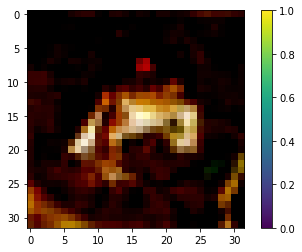

In [51]:
plt.imshow(train_x[0].reshape(32, 32, 3))
plt.colorbar()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

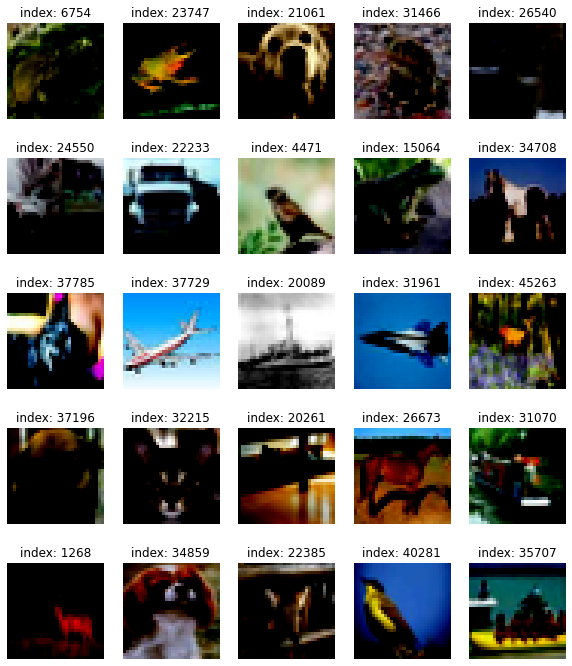

In [52]:
plt.figure(figsize=(10, 12))

for idx, random_index in enumerate(np.random.randint(0, len(train_x), size = 25),1):
    plt.subplot(5, 5, idx)
    plt.imshow(train_x[random_index].reshape(32, 32, 3), cmap='gray')
    plt.title(f'index: {random_index}')
    plt.axis('off')
plt.show()

In [160]:
BUFFER_SIZE = 50000
BATCH_SIZE = 512

- 텐서플로우 공식 문서: [tf.data.Dataset](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle)
  - 데이터가 잘 섞이게 하려면 Buffer_Size > 총 데이터 개수

In [85]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## STEP 2. 생성자 모델 구현하기

# GAN
- 생성자 vs 판별자
  - 생성자 : 자기가 생성한 Fake Image를 판별자가 진짜라고 판단하도록 속이고 싶어 
  - 판별자 : 생성자가 생성한 가짜 이미지를 가짜로, 진짜 이미지를 진짜로 잘 판별하는 것
## 생성자 구현하기
- 참고자료
1. [Generative Models - openai](https://openai.com/blog/generative-models/)
     - Input : 100 random numbers drawn from a uniform distribution (called as a code, or latent variables)
     - Output : an image (in this case 64x64x3 images)
     - 생성모델 기법: GAN, Variational Autoencoders (VAEs), Autoregressive models (ex. Pixel RNN)
2.[Tensorflow 2.0 Tutorial의 DCGAN 구현](https://www.tensorflow.org/tutorials/generative/dcgan?hl=ko)
3.[러닝 텐서플로- Chap07.3 - 텐서플로 추상화와 간소화, Keras](https://excelsior-cjh.tistory.com/159)
  - [What is Transposed Convolutional Layer?](https://towardsdatascience.com/what-is-transposed-convolutional-layer-40e5e6e31c11)
  - [라온피플-Batch Normalization](https://m.blog.naver.com/laonple/220808903260)
  - [활성화 함수 (activation function)](https://newly0513.tistory.com/20)

In [86]:
def make_generator_model():

    # Start
    #텐서플로우 2.0 이후 버전에서는 레이어와 모델에 call 메소드를 구현
    #방금 만들어진 생성자 모델에 입력값으로 노이즈를 넣고 바로 모델을 호출하면 간단히 결과 이미지가 생성
    #내부적으로는 생성자의 call 함수가 호출
    #학습하는 중이 아닐때는 training=False와 함께 호출 → BN의 훈련 시기와  추론 시기의 행동이 다른 부분 조정
    model = tf.keras.Sequential()
    

    # First: Dense layer
    #모델은 입력값으로 (batch_size, 100) 형상의 노이즈 벡터를 받습니다.
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    #입력된 (batch_size, 100) 벡터는 7 x 7 x 256 = 12544개의 노드를 가진 첫 번째 Dense 레이어를 거치며 (batch_size, 12544) 형상의 벡터가 됩니다.
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.5))

    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, 256)))
    #첫 번째 레이어를 지난 후 벡터는 Reshape 레이어를 지나게 됩니다.
    #이는 이후의 Layer에서 Convolutional 연산을 할 수 있도록 1차원 벡터를 (7, 7, 256) 형상의 3차원 벡터로 변환시키는 작업입니다.

    # Third: Conv2DTranspose layer
    #(8, 8, 256) → (8, 8, 128) → (16, 16, 64) → (32, 32, 3) 순으로 이미지를 키움
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    #신경망의 가중치가 폭발하지 않도록 가중치 값을 정규화
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.5))

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.5))

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))
    #tanh: -1 ~ 1 이내의 값으로 픽셀값을 정규화시켰던 데이터셋과 동일하게

    return model

In [87]:
generator = make_generator_model()

generator.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 16384)             1638400   
_________________________________________________________________
batch_normalization_10 (Batc (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 16384)             0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 16384)             0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose_6 (Conv2DTr (None, 8, 8, 128)         819200    
_________________________________________________________________
batch_normalization_11 (Batc (None, 8, 8, 128)        

In [88]:
#input용 random 벡터
noise = tf.random.normal([1, 100])

In [89]:
generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 32, 32, 3])

- [1, 32, 32, 3] 사이즈의 이미지
- [batch size, weight, height, kernel]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


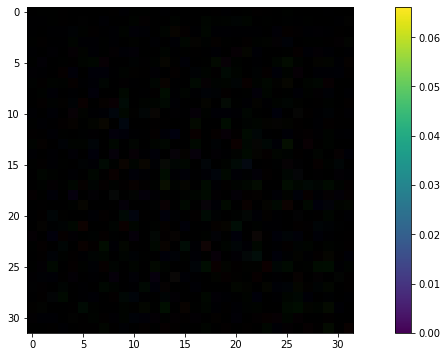

In [90]:
plt.imshow(generated_image[0, :, :, :])
plt.colorbar()
plt.show()

## STEP 3. 판별자 모델 구현하기

## 판별자 구현하기 

In [122]:
def make_discriminator_model():
    '''
    입력: (28, 28, 1) 크기의 이미지
    출력: 단 하나의 숫자(진짜라고 판단하는 정도)
    '''
    # Start
    model = tf.keras.Sequential()

    #Conv: (28, 28, 1) → (14, 14, 64) → (7, 7, 128)
    #Conv: (32, 32, 3) → (16, 16, 64) → (8, 8, 128)
    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(1, 1), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.5))
    model.add(layers.AveragePooling2D(pool_size = (2,2), strides=(2, 2)))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(1, 1), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.5))
    model.add(layers.AveragePooling2D(pool_size = (2,2), strides=(2, 2)))

    # Third: Flatten Layer
    #Flatten: 3차원 이미지를 1차원으로 쭉 펴서 8x8x128=8192, 즉 (1, 8192) 형상의 벡터로 변환
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model

In [123]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 32, 32, 64)        4864      
_________________________________________________________________
batch_normalization_23 (Batc (None, 32, 32, 64)        256       
_________________________________________________________________
leaky_re_lu_25 (LeakyReLU)   (None, 32, 32, 64)        0         
_________________________________________________________________
dropout_22 (Dropout)         (None, 32, 32, 64)        0         
_________________________________________________________________
average_pooling2d_9 (Average (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 16, 16, 128)       204928    
_________________________________________________________________
batch_normalization_24 (Batc (None, 16, 16, 128)     

In [124]:
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.00272364]], dtype=float32)>

## STEP 4. 손실함수와 최적화 함수 구현하기

# 학습: 손실함수와 최적화 함수 

## 손실함수(loss function)
- 교차 엔트로피(Cross Entropy): 
  - 점점 가까워지기 원하는 두 값이 얼마나 큰 차이가 나는지를 정량적으로 계산
  - 한 개의 이미지가 가짜인지 진짜인지 나타내는 2개 클래스 간 분류 문제를 풀어야 함
  - 이진 교차 엔트로피(binary cross entropy)
- 생성자 vs 판별자
  - 생성자 : 자기가 생성한 Fake Image를 판별자가 진짜라고 판단하도록 속이고 싶어 
    - 판별자가 Fake Image에 대해 판별한 값, 즉 D(fake_image) 값이 1에 가까워지는 것
  - 판별자 : 생성자가 생성한 가짜 이미지를 가짜로, 진짜 이미지를 진짜로 잘 판별하는 것
    - Real Image 판별값, 즉 D(real_image)는 1에, Fake Image 판별값, 즉 D(fake_image)는 0에 가까워지는 것

- [tf.keras.losses.BinaryCrossentropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/BinaryCrossentropy#args_1)
  - from_logits = True : input으로 오는 값이 실수 전체일 경우 → 함수 내부에서 sigmoid함수를 이용해 0 ~ 1 사이로 정규화 한 후 계산

In [125]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

- fake_output : 생성자가 생성한 Fake Image를 구분자에 입력시켜서 판별된 값, 즉 D(fake_image)
- real_output : 기존에 있던 Real Image를 구분자에 입력시켜서 판별된 값, 즉 D(real_image)
- WITH
    - tf.one_like()
    - tf.zeros_like()

### generator_loss
- generator_loss는 fake_output가 1에 가까워지기를 바라므로, 다음과 같이 tf.ones_like와의 교차 엔트로피값을 계산
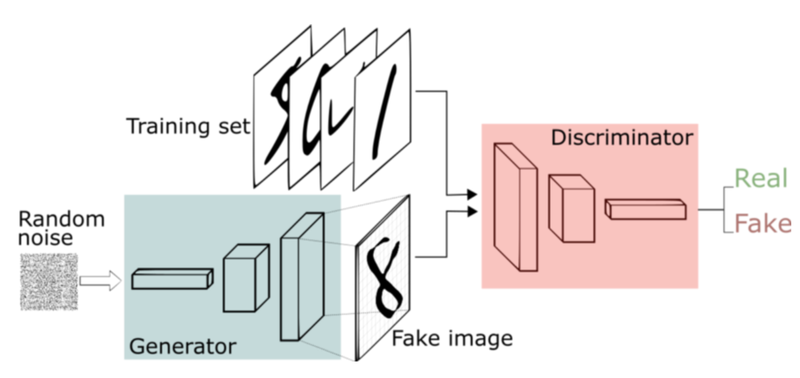

In [126]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)
#fake_output은 하나의 값인가 ? 아니면 그림 그 자체인가 ? discriminate한 결과값[ 0,1 ]
#왜 1이랑 비교하는거지 ? generate한 fake image가 다 1로 판별 받았으면 좋겠으니까!

### discriminator_loss
- 반면, discriminator_loss
  - real_output → 1 : 1로 채워진 벡터
  - fake_output → 0 : 0으로 채워진 벡터

In [161]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
#     real_loss = cross_entropy(tf.random.uniform(real_output.shape, minval=0.7, maxval=1.2, dtype=tf.dtypes.float32), real_output)
#     fake_loss = cross_entropy(tf.random.uniform(fake_output.shape, minval=0.0, maxval=0.3, dtype=tf.dtypes.float32), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### discriminator accuracy : 좀 헷갈리는데
- 진짜와 가짜를 구별하지 못해야 한다: 0.5로 수렴하라

In [128]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

[예시]
real_output = tf.Tensor(0.2, 0.4, 0.7, 0.9) 이미지 하나 당 하나의 값[0, 1]이 있는 거야
- 구별 못하게끔 생성하는 것도 중요하지만, 얘가 구별 자체를 잘하는 것도 중요하지 않아 ?

- (1) tf.math.greater_equal(real_output, tf.constant(0.5)) : real_output의 각 원소가 0.5 이상인지 True, False로 판별 - >> tf.Tensor([False, False, True, True])
- (2) tf.cast( (1), tf.float32) : (1)의 결과가 True이면 1.0, False이면 0.0으로 변환 - >> tf.Tensor([0.0, 0.0, 1.0, 1.0])
- (3) tf.reduce_mean( (2)) : (2)의 결과를 평균내어 이번 배치의 정확도(accuracy)를 계산 - >> 0.5


## 최적화 함수(optimizer)
- 참고자료 : [문과생도 이해하는 딥러닝 (8) - 신경망 학습 최적화](https://sacko.tistory.com/42)

In [129]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.3)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-3, beta_1=0.3)
# discriminator_optimizer = tf.keras.optimizers.SGD(1e-5)

In [130]:
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

참고자료
- https://kangbk0120.github.io/articles/2017-08/dcgan-pytorch

## STEP 5. 훈련과정 상세 기능 구현하기

## 훈련과정 설계
- 참고자료
  - 데코레이터 : [python decorator (데코레이터) 어렵지 않아요](https://bluese05.tistory.com/30)
  - @tf.function : [Tensorflow Tutorial](https://www.tensorflow.org/api_docs/python/tf/function)

In [131]:
@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

In [132]:
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, :])
        plt.axis('off')
   
    try:
        plt.savefig('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it))
        plt.show()
    except:
        pass

 train_step() 함수가 리턴하는 gen_loss, disc_loss, real_accuracy, fake_accuracy 이상 4가지 값을 history라는 dict 구조에 리스트로 저장하고 있다가 매 epoch마다 시각화하는 함수를 만들어 봅시다. 예를 들어 생성자의 loss의 history는 history['gen_loss']로 접근할 수 있는 list로 관리할 예정입니다.

In [133]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('{}/aiffel/dcgan_newimage/fashion/training_history/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()

In [134]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints3'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## STEP 6. 학습 과정 진행하기

In [135]:
def train(dataset, epochs, save_every, checkpoint_prefix):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [136]:
# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

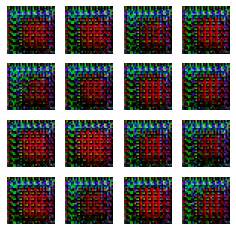

Time for training : 222 sec


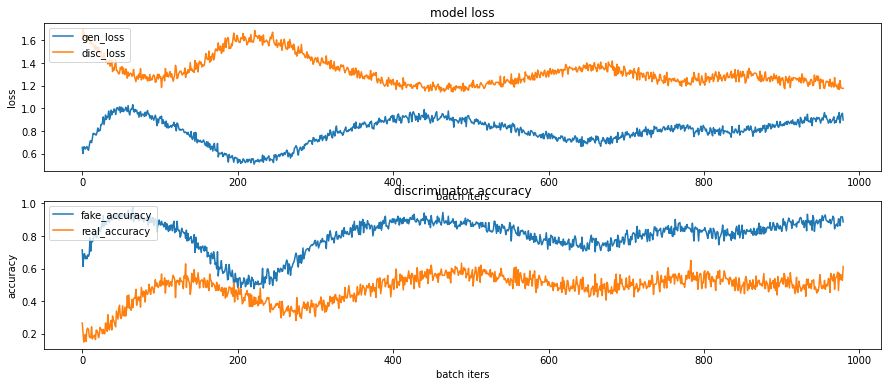

CPU times: user 3min 39s, sys: 5.87 s, total: 3min 45s
Wall time: 3min 42s


In [137]:
%%time
save_every = 5
EPOCHS = 5
train(train_dataset, EPOCHS, save_every, checkpoint_prefix)

# 학습과정의 loss, accuracy 그래프 이미지 파일이 ~/aiffel/dcgan_newimage/fashion/training_history 경로에 생성되고 있으니
# 진행 과정을 수시로 확인해 보시길 권합니다.

- gif 이미지 만들기 BY PACKAGE: imageio

In [155]:
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/generated_samples/cifar10_dcgan.gif'
with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('./cifar10/generated_samples/sample*')
    filenames = sorted(filenames)
    last = -1
    print(filenames)
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/cifar10/cifar10_dcgan.gif

['./cifar10/generated_samples/sample_epoch_0001_iter_001.png', './cifar10/generated_samples/sample_epoch_0001_iter_051.png', './cifar10/generated_samples/sample_epoch_0001_iter_101.png', './cifar10/generated_samples/sample_epoch_0001_iter_151.png', './cifar10/generated_samples/sample_epoch_0002_iter_001.png', './cifar10/generated_samples/sample_epoch_0002_iter_051.png', './cifar10/generated_samples/sample_epoch_0002_iter_101.png', './cifar10/generated_samples/sample_epoch_0002_iter_151.png', './cifar10/generated_samples/sample_epoch_0003_iter_001.png', './cifar10/generated_samples/sample_epoch_0003_iter_051.png', './cifar10/generated_samples/sample_epoch_0003_iter_101.png', './cifar10/generated_samples/sample_epoch_0003_iter_151.png', './cifar10/generated_samples/sample_epoch_0004_iter_001.png', './cifar10/generated_samples/sample_epoch_0004_iter_051.png', './cifar10/generated_samples/sample_epoch_0004_iter_101.png', './cifar10/generated_samples/sample_epoch_0004_iter_151.png', './cifa

- 체크포인트를 이용해 모델 로드하기

In [28]:
type(checkpoint)

tensorflow.python.training.tracking.util.Checkpoint

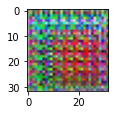

In [157]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints3'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

# 로드한 모델이 정상적으로 이미지를 생성하는지 확인해 봅니다. 
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
np_generated = np_generated.astype(int)
fig = plt.figure(figsize=(1.5,1.5))
plt.imshow(np_generated[0])
plt.show()  # 정상적으로 모델이 로드되었다면 랜덤 이미지가 아니라 CIFAR-10 이미지가 그려질 것입니다.

### 재훈련

- [체크포인트 재훈련](https://www.tensorflow.org/guide/checkpoint?hl=ko)

#### 재훈련 1 : 
- 생성자 모델 Dropout추가
- 판별자 모델 BN추가, Dropout 0.5, Pooling추가
- 라벨 0, 1 에서 0.7~1.2 / 0.0~0.3 범주로 사용

In [158]:
# opt = tf.keras.optimizers.Adam(0.1)
# net = Net()
# ckpt = tf.train.Checkpoint(step=tf.Variable(1), optimizer=opt, net=net)
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints3'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

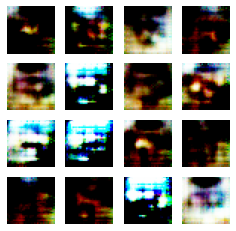

Time for training : 2189 sec


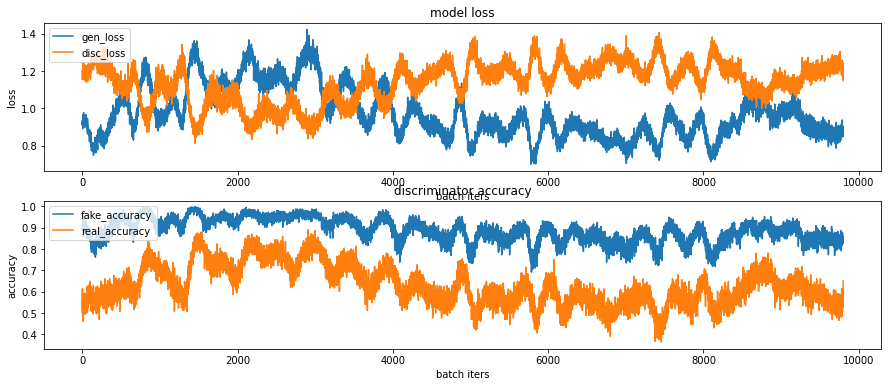

CPU times: user 36min 23s, sys: 25.8 s, total: 36min 49s
Wall time: 36min 30s


In [159]:
%%time
save_every = 5
EPOCHS = 50
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
train(train_dataset, EPOCHS, save_every, checkpoint_prefix)

# 학습과정의 loss, accuracy 그래프 이미지 파일이 ~/aiffel/dcgan_newimage/fashion/training_history 경로에 생성되고 있으니
# 진행 과정을 수시로 확인해 보시길 권합니다.

## STEP 7. (optional) GAN 훈련 과정 개선하기

- STEP 6을 진행하면서 생성된 샘플 이미지, 학습 과정 그래프 등을 통해 이전 훈련 과정의 문제점을 분석해 봅시다.
- 모델구조 또는 학습 과정을 개선한 내역과 그 결과(샘플 이미지, 학습 과정 그래프 포함)를 함께 제출합니다.

1. Normalize the inputs [Done]
2. A modified loss function 
3. Use a spherical Z [Done]
4. BatchNorm
   - discriminator 에 batch norm 추가
5. Avoid Sparse Gradients: ReLU, MaxPool
   - discriminator 에 avg pooling 추가
6. Use Soft and Noisy Labels
   - dixcriminator loss 에 tf.random 추가
7. DCGAN / Hybrid Models
8. Use stability tricks from RL
9. Use the ADAM Optimizer
   - Use SGD for discriminator and ADAM for generator
10. Track failures early
11. Dont balance loss via statistics (unless you have a good reason to)
12. If you have labels, use them
13. Add noise to inputs, decay over time
~~14. [notsure] Train discriminator more (sometimes)~~
~~15. [notsure] Batch Discrimination~~
~~16. Discrete variables in Conditional GANs~~
17. Use Dropouts in G in both train and test phase
    - D dropout 0.5로 조정, G에도 추가



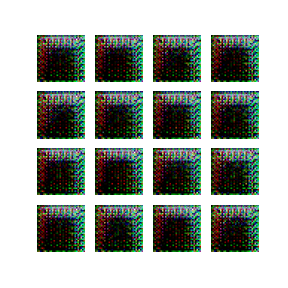

참고자료
- [How to Train a GAN? Tips and tricks to make GANs work](https://github.com/soumith/ganhacks)
- [10 Lessons I Learned Training GANs for one Year](https://towardsdatascience.com/10-lessons-i-learned-training-generative-adversarial-networks-gans-for-a-year-c9071159628)
- [Tips for Training Stable Generative Adversarial Networks](https://machinelearningmastery.com/how-to-train-stable-generative-adversarial-networks/)
- [Improved Techniques for Training GANs(paper)](https://papers.nips.cc/paper/6125-improved-techniques-for-training-gans.pdf)

# 결론 및 회고
- 해당 노드는 DCGAN으로 CIFAR10 데이터를 학습하는 내용이었다.
- 이전 노드들에 이어지는 내용이라 tensorflow로 layer를 쌓는방법에 대한 이해는 있었으나
- 생성자, 판별자라는 모델이 엮이고 이 둘의 로스를 동시에 계산하고 최적화 하는 등의 방식이 이해하기 매우 까다로웠다.
- 따라서 결과도 원하는 만큼 잘 나오지 않았고, 어떤 파라미터를 움직여서 변화시켜야 할지에 대한 감각은 전혀 없었다. 그저 시도하고 시도할 뿐이었다.
- 그런 과정에서 먼저 연구한 사람들의 글을 읽는 것은 큰 위안이 되었다.(제대로 적용하지 못했는지 큰 도움은 되지 않았지만.)
- PRML이나 밑시딥을 통해 공부한다면 더 잘 이해하고 더 잘 적용할 수 있을까?
- CV는 나에게 매우 공학적으로 다가오고, 어떤 식으로 접근해야할지 난해한 파트이다.
